# IA318 - Reinforcement Learning

# Dynamic programming

This notebook presents techniques of dynamic programming (**policy iteration, value iteration**) for the Maze.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import sparse

In [2]:
from model import Maze, Agent

In [3]:
cmap = 'seismic'

In [4]:
maze = Maze()
maze_map = np.load('maze.npy')
maze.set_parameters(maze_map, (1,0), [(1,20)])
maze = Maze()

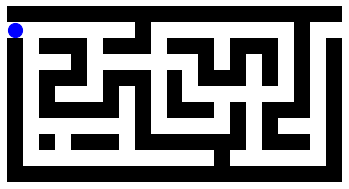

In [5]:
maze.display()

In [6]:
class Evaluation:
    """Evaluation of a policy.
    """
    def __init__(self, maze, policy, gamma=0.9, n_iter=200):
        self.maze = maze
        self.policy = policy
        self.gamma = gamma
        self.shape = maze.Map.shape
        self.get_transition_matrix()
        self.get_rewards()
        self.get_values(n_iter)
        
    def get_transitions(self, state):
        probs = []
        states = []
        if self.maze.is_valid(state) and not self.maze.is_terminal(state):
            for prob, action in zip(*self.policy(state)):
                probs_, states_ = self.maze.get_transition(state, action)
                probs += list(prob * np.array(probs_))
                states += states_
        return probs, states
    
    def get_transition_matrix(self):    
        n, m = self.shape
        row = []
        col = []
        data = []
        for i in range(n * m):
            state = np.array([i // m, i % m])
            probs, states = self.get_transitions(state)
            if states:
                indices = [state_[0] * m + state_[1] for state_ in states]
                row += len(indices) * [i]
                col += indices
                data += probs
        self.transition = sparse.csr_matrix((data, (row, col)), shape=(n * m, n * m))

    def get_rewards(self):
        n, m = self.shape
        rewards = []
        for i in range(n * m):
            reward = 0
            state = np.array([i // m, i % m])
            if self.maze.is_valid(state):
                reward = self.maze.get_reward(state)
            rewards.append(reward)
        self.rewards = rewards
    
    def get_values(self, n_iter):
        n, m = self.shape
        values = np.zeros(n * m)
        rewards = np.array(self.rewards)
        for t in range(n_iter):
            values = self.transition.dot(rewards + self.gamma * values)
        self.values = values

In [7]:
# first policy
policy = Agent(Maze()).policy

In [9]:
evaluation = Evaluation(maze, policy)

In [10]:
values = evaluation.values

In [11]:
def display_values(values):
    n, m = maze.Map.shape
    image = values.copy().reshape(n, m) + 0.7
    image *= maze.Map
    plt.imshow(image, cmap=cmap)
    plt.axis('off')
    plt.show()

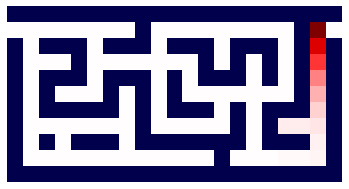

In [12]:
display_values(values)

In [13]:
def improve_policy(evaluation):
    n, m = evaluation.shape
    values = evaluation.values
    rewards = evaluation.rewards
    gamma = evaluation.gamma
    best_actions = []
    for i in range(n * m):
        state = np.array([i // m, i % m])
        if maze.is_valid(state):
            actions = maze.get_actions(state)
            rewards_actions = []
            for action in actions:
                probs, states = maze.get_transition(state, action)
                indices = [state_[0] * m + state_[1] for state_ in states]
                rewards_actions.append(np.sum(np.array(probs) * (rewards + gamma * values)[indices]))
            best_actions.append(actions[np.argmax(rewards_actions)])
        else:
            best_actions.append((0, 0))
    # policy(state) -> probs, actions
    policy = lambda state: [[1], [best_actions[state[0] * m + state[1]]]]
    return policy

In [14]:
def get_action(policy, state):
    probs, actions = policy(state)
    return actions[0]

In [15]:
policy = improve_policy(evaluation)

In [16]:
evaluation = Evaluation(maze, policy)

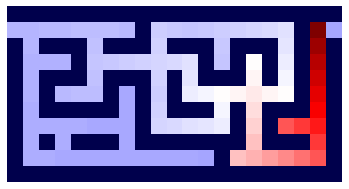

In [17]:
display_values(evaluation.values)

In [18]:
def get_path(policy, n_step = 100):
    state = maze.init_state()
    states = [state]
    for t in range(n_step):
        action = get_action(policy, state)
        _, states_ = maze.get_transition(state, action)
        state = states_[0]
        states.append(state)
        if maze.is_terminal(state):
            break
    return states

In [19]:
states = get_path(policy)

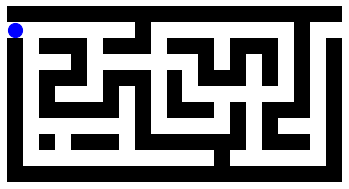

In [20]:
animation = maze.display(states)

In [21]:
animation

## To do

Find the optimal policy by value iteration.